# CSE150A Milestone 3: Multinomial HMM for Weather Prediction

## Importing and Preprocessing Data

In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('seattle-weather.csv')

In [2]:
#discretize weather
def discretize_weather(w):
    if w == 'drizzle': return 0
    elif w == 'rain': return 1
    elif w == 'sun': return 2
    elif w == 'snow': return 3
    elif w == 'fog': return 4

df['weather_cat'] = df['weather'].apply(discretize_weather)

#make sure typing is correct
df['weather_cat'] = df['weather_cat'].astype(int)
print(df.dtypes)

date              object
precipitation    float64
temp_max         float64
temp_min         float64
wind             float64
weather           object
weather_cat        int32
dtype: object


In [3]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather,weather_cat
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,0
1,2012-01-02,10.9,10.6,2.8,4.5,rain,1
2,2012-01-03,0.8,11.7,7.2,2.3,rain,1
3,2012-01-04,20.3,12.2,5.6,4.7,rain,1
4,2012-01-05,1.3,8.9,2.8,6.1,rain,1


In [4]:
#dropping the values for date and weather for easier processing
df.drop(['date', 'weather'], axis=1, inplace=True)
df = df.dropna()
df.head()

,precipitation,temp_max,temp_min,wind,weather_cat
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,1
2,0.8,11.7,7.2,2.3,1
3,20.3,12.2,5.6,4.7,1
4,1.3,8.9,2.8,6.1,1


In [5]:
#discrete values check
print(df['weather_cat'].unique())  # Should be [0, 1, 2, 3, 4]

#map for weather
weather_map = {0: 'drizzle', 1: 'rain', 2: 'sun', 3: 'snow', 4: 'fog'}

[0 1 2 3 4]


## Model Training

In [6]:
#Get a single feature vector for obs/labels
X = df[['precipitation', 'temp_max', 'temp_min', 'wind']].values #observations
Y = df['weather_cat'].values

#split training and test data
X_train, X_test ,Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#Define and train the Gaussian HMM
n_states = 5
model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(X_train)

#Code written colaboratively and taken from Chat GPT-4o:
#Prompt: I asked Chatgpt why the accuracy for the GaussianHMM was so bad before, and it suggested not using the discrete mapping we had initially which was interefering with our accuracy
#Predict hidden states for the test set
predicted_states_train = model.predict(X_train)

print("Transition matrix:\n", model.transmat_)  # Probability of moving between states
print("\nMeans of each state:\n", model.means_)  # Average values for each feature in each state
print("\nCovariances:\n", model.covars_)  # Variability in each state

#Map each hidden state to the most common label in training data
state_to_label = {}
for state in range(n_states):
    mask = (predicted_states_train == state)  # Find all samples assigned to this state
    if np.sum(mask) > 0:  # Avoid empty clusters
        state_to_label[state] = mode(Y_train[mask]).mode[0]

#Convert hidden states to predicted weather labels
mapped_predictions = np.array([state_to_label[state] for state in predicted_states_train])

Transition matrix:
 [[0.05510219 0.53292603 0.04089403 0.18085499 0.19022277]
 [0.09831059 0.5804644  0.07066919 0.14455087 0.10600494]
 [0.09462197 0.55322831 0.14306902 0.0923283  0.1167524 ]
 [0.0516527  0.60022603 0.07217913 0.13018346 0.14575868]
 [0.09072487 0.50737224 0.10178327 0.14914903 0.15097059]]

Means of each state:
 [[ 0.70282944 15.89282016  8.95845593  2.70264821]
 [ 0.         18.9200033   8.89785086  2.8897002 ]
 [ 7.70438253 18.80732909 12.36302265  3.23241298]
 [12.30322033 12.73274697  7.49927518  4.50722918]
 [ 5.45222119  8.18068045  3.17131118  3.84787239]]

Covariances:
 [[[1.78354027e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 3.22997198e+01 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.66766187e+01 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.13606199e+00]]

 [[1.50671000e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 5.97371383e+01 0.00000000e+00 0.00000000e+00]
  [0.0000

C:\Users\sword\AppData\Local\Temp\ipykernel_5800\2455612181.py:27: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  state_to_label[state] = mode(Y_train[mask]).mode[0]


In [7]:
#Training data summary
conf_matrix_train = confusion_matrix(Y_train, mapped_predictions)
accuracy_train = accuracy_score(Y_train, mapped_predictions)

print("Confusion Matrix:\n", conf_matrix_train)
print("\nAccuracy Score:", accuracy_train)

Confusion Matrix:
 [[  0   0  44   0   0]
 [  0 485  36   0   0]
 [  0   1 508   0   0]
 [  0  18   0   0   0]
 [  0   0  76   0   0]]

Accuracy Score: 0.8501712328767124


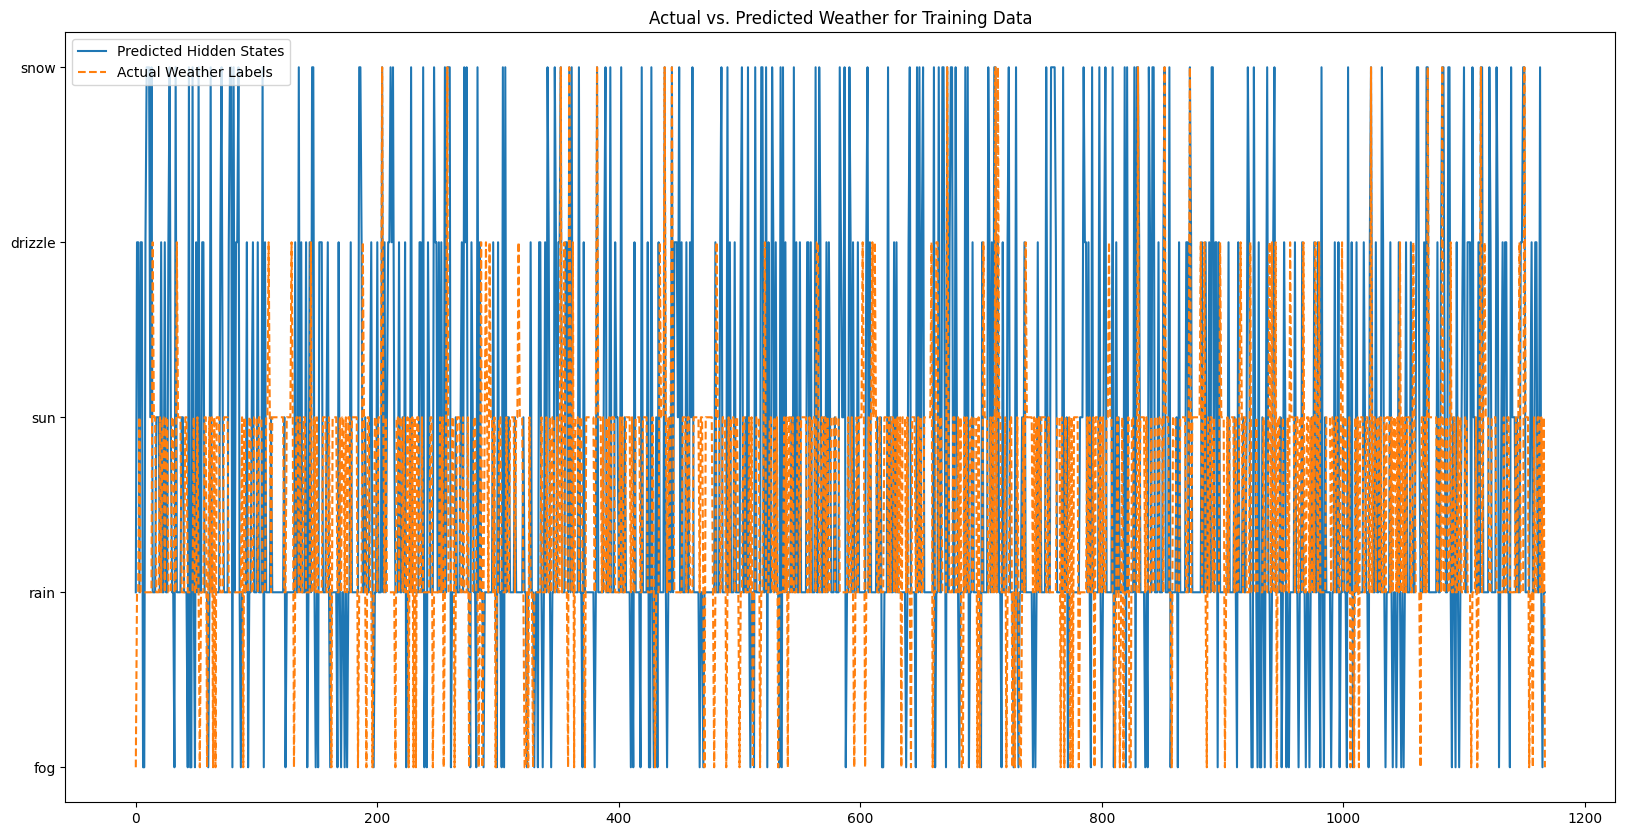

In [8]:
#Graph for training data
wlabels_train = [weather_map[label] for label in Y_train]
plt.figure(figsize = (20,10))
plt.plot(predicted_states_train, label="Predicted Hidden States")
plt.plot(wlabels_train, label="Actual Weather Labels", linestyle="dashed")
plt.title("Actual vs. Predicted Weather for Training Data")
plt.legend()
plt.show()

## Model Testing

In [9]:
#Now use the model on the test set
predicted_states_test = model.predict(X_test)
mapped_predictions_test = np.array([state_to_label[state] for state in predicted_states_test])

#Test data summary
conf_matrix_test = confusion_matrix(Y_test, mapped_predictions_test)
accuracy_test = accuracy_score(Y_test, mapped_predictions_test)

print("Confusion Matrix:\n", conf_matrix_test)
print("\nAccuracy Score:", accuracy_test)

Confusion Matrix:
 [[  0   0   9   0   0]
 [  0 112   8   0   0]
 [  0   0 131   0   0]
 [  0   8   0   0   0]
 [  0   0  25   0   0]]

Accuracy Score: 0.8293515358361775


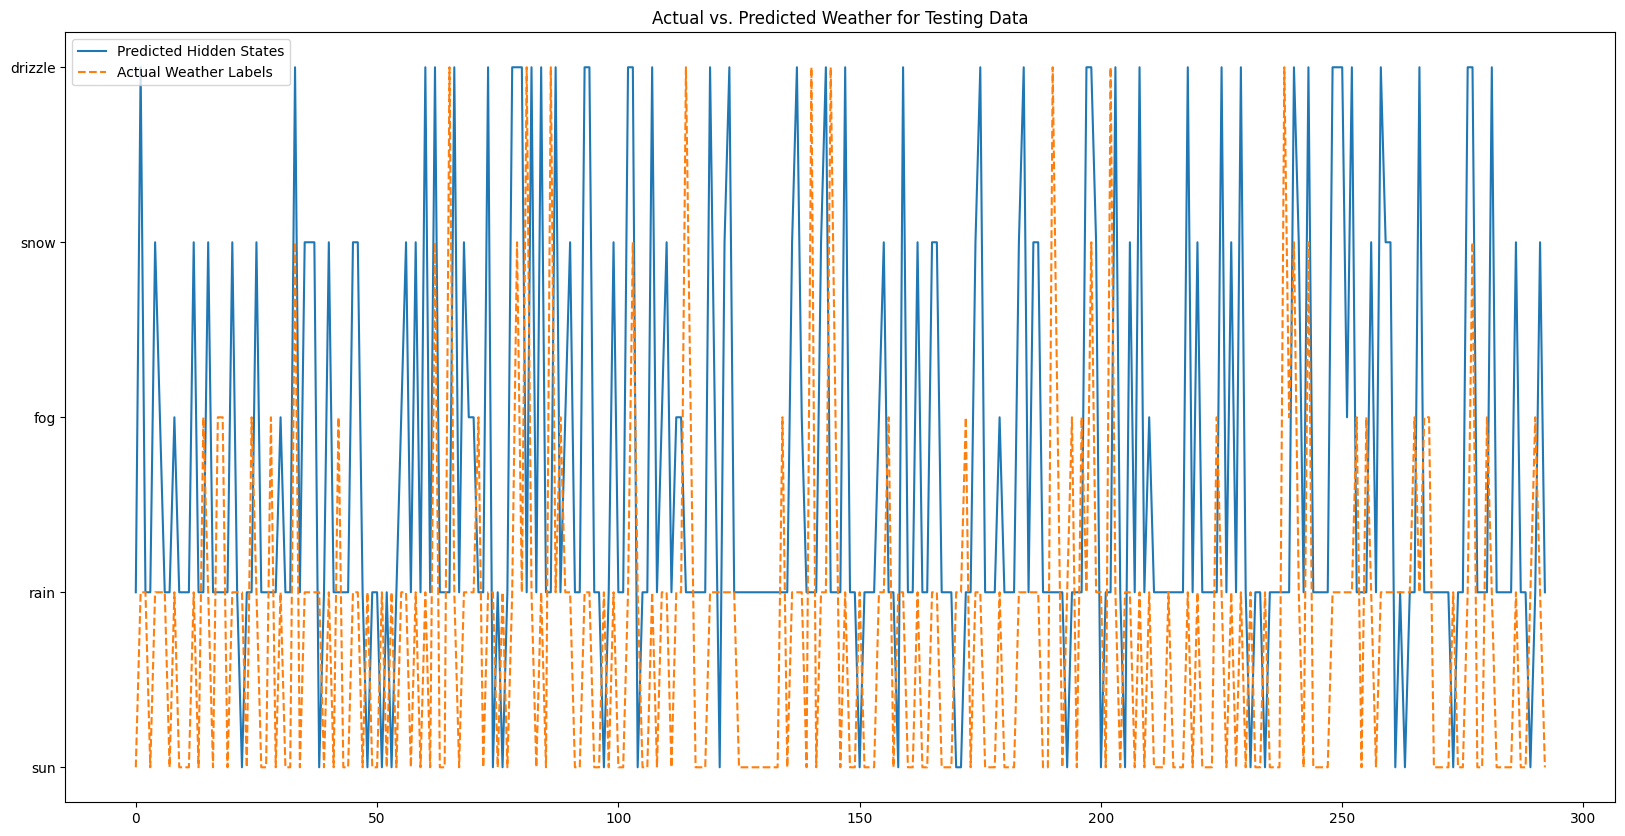

In [10]:
#Graph for test data
wlabels_test = [weather_map[label] for label in Y_test]
plt.figure(figsize = (20,10))
plt.plot(predicted_states_test, label="Predicted Hidden States")
plt.plot(wlabels_test, label="Actual Weather Labels", linestyle="dashed")
plt.title("Actual vs. Predicted Weather for Testing Data")
plt.legend()
plt.show()